## A/B тест крупного интернет-магазина

Аналитика крупного интернет-магазина. Вместе с отделом маркетинга подготовлен список гипотез для увеличения выручки.
Требуется приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

### Содержание:
* [Часть 1. Приоритизация гипотез](#first-bullet)
* [Применение фреймворка ICE для приоритизации гипотез](#second-bullet)
* [Применение фреймворка RICE для приоритизации гипотез](#third-bullet)
* [Часть 2. Анализ A/B-теста](#fourth-bullet)
* [График стоимости заказов по пользователям](#fifth-bullet)
* [График количества заказов по пользователям](#sixth-bullet)    
* [График кумулятивной конверсии по группам](#seventh-bullet)
* [График относительного изменения кумулятивной конверсии группы B к группе A](#eight-bullet)
* [График кумулятивной выручки по группам](#ninth-bullet)
* [График кумулятивного среднего чека по группам](#tenth-bullet)
* [График относительного изменения кумулятивного среднего чека группы B к группе A](#eleventh-bullet)
* [Подсчет статистической значимости различий в конверсии между группами по «сырым» данным](#twelveth-bullet)
* [Оценка статистической значимости различия средних чеков между группами](#therteen-bullet)
* [Очищение данных от аномалий](#fourteen-bullet)
* [Подсчёт статистической значимости различий в конверсии между группами по «очищенным» данным](#fifteen-bullet)
* [Подсчет статистической значимости различия средних чеков после удаления аномальных пользователей](#sixteen-bullet)
* [Выводы А/В теста](#seventeen-bullet)
* [Общие выводы](#eighteen-bullet)

### Часть 1. Приоритизация гипотез <a class="anchor" id="first-bullet">

#### Задача
* Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
* Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
* Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
import scipy.stats as stats
import seaborn as sns 

In [2]:
#импорт данных
try:
    hypothesis = pd.read_csv('C:/Users/Sveta/Downloads/hypothesis.csv')
    orders = pd.read_csv('C:/Users/Sveta/Downloads/orders.csv')
    visitors = pd.read_csv('C:/Users/Sveta/Downloads/visitors.csv')

except FileNotFoundError:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')  
display(hypothesis)
display(orders.head())
display(visitors.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [3]:
# информация о таблицах 
hypothesis.info()
orders.info()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   

* Пропусков данных не обнаружено
* Требуется перевести названия столбцов таблицы hypothesis к нижнему регистру
* В таблицах visitors и orders необходимо преобразовать тип данных столбцов с датами

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [5]:
# поиск дубликатов
print(hypothesis.duplicated().sum())
print(orders.duplicated().sum())
print(visitors.duplicated().sum())

0
0
0


Дубликаты данных в таблицах не обнаружены

Проверка пользователей, которые попали в 2 теста одновременно:

In [6]:
users_AB = orders.groupby('visitorId').agg({'group':'nunique'})
users_AB = users_AB.query('group != 1')
users_AB['group'].count()

58

В двух группах А/B теста одновременно находится 58 покупателей

#### Применение фреймворка ICE для приоритизации гипотез <a class="anchor" id="second-bullet">

ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») — один из самых популярных способов приоритизации задач

In [7]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
hypothesis['ICE']= (hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
hypothesis_ice = hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False).round(0)
display(hypothesis_ice)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


#### Применение фреймворка RICE для приоритизации гипотез <a class="anchor" id="third-bullet">

Фреймворк RICE состоит из четырёх компонент:
* Reach — скольких пользователей затронет изменение, которое вы хотите внести;
* Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
* Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так;
* Efforts — сколько стоит протестировать эту гипотезу.

In [8]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis_rice = hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False).round(0)
display(hypothesis_rice)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [9]:
# объединение двух таблиц
hypothesis_merged = hypothesis_ice.merge(hypothesis_rice, on = 'hypothesis')
hypothesis_merged['ICE'] = hypothesis_merged['ICE'].astype('int')
hypothesis_merged['RICE'] = hypothesis_merged['RICE'].astype('int')
pallete = sns.light_palette("blue", as_cmap=True)
hypothesis_merged.style.background_gradient(cmap=pallete)


,hypothesis,ICE,RICE
0,"Запустить акцию, дающую скидку на товар в день рождения",16,16
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13,40
2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11,112
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8,40
4,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7,56
5,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,4
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1,4
7,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1,9
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1,3


* Приоритезация гипотез при применении фреймворка RICE не совпадает с приоритезацией при применении фреймворка ICE в связи с тем, что фреймворк RICE включает в числе компонент Reach, который отвечает за оценку количества пользователей, которых затронет вносимое изненение
* Параметры impact (влияние), confidence (уверенность), effort (усилия) применимы как для фреймворка ICE, так и для фреймворка RICE 
* Таким, образом, без учета охвата самая приоритетная гипотеза 8 (запустить акцию на день рождения), а с учетом охвата самая приоритетная - 7 (добавить форму подписки на основные страницы)

### Часть 2. Анализ A/B-теста <a class="anchor" id="fourth-bullet">

Задача
Проанализируйте A/B-тест:
* Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
* Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
* Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
* Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.
* Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.
* Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
* Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
* Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
* Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
* Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.
* Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
* Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.
* Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
* Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

#### График стоимости заказов по пользователям <a class="anchor" id="fifth-bullet">

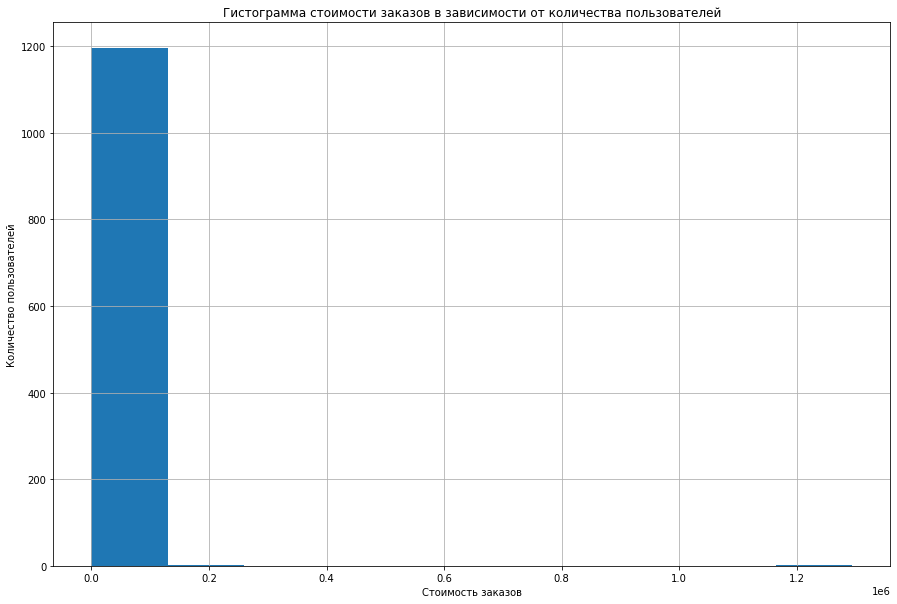

In [10]:
plt.figure(figsize=(15, 10))
plt.hist(orders['revenue'])
plt.grid()
plt.title('Гистограмма стоимости заказов в зависимости от количества пользователей')
plt.xlabel("Стоимость заказов")
plt.ylabel("Количество пользователей")
plt.show()

* Гистограмма зависимости стоимости заказов показывает, что большинство заказов не превышают по стоимости 100000 рублей

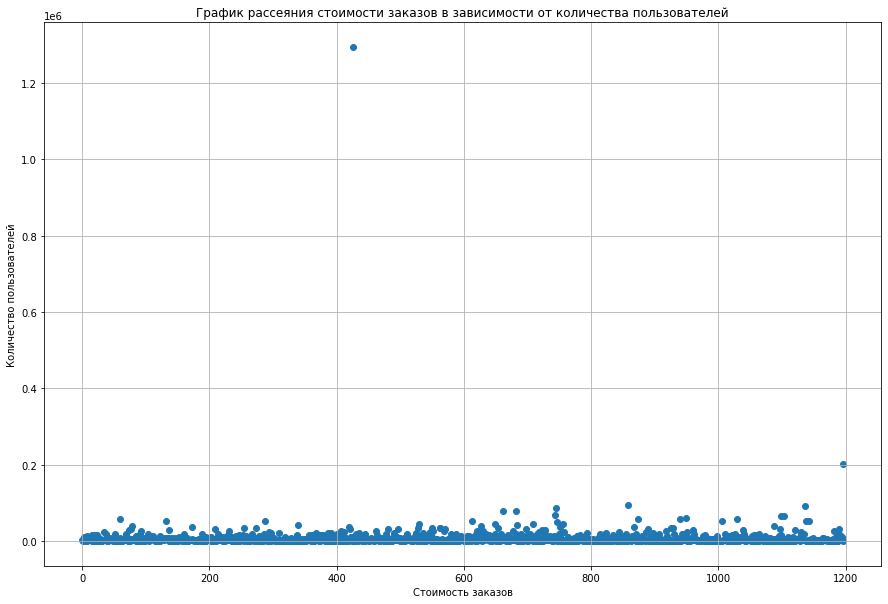

In [11]:
plt.figure(figsize=(15, 10))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.grid()
plt.title('График рассеяния стоимости заказов в зависимости от количества пользователей')
plt.xlabel("Стоимость заказов")
plt.ylabel("Количество пользователей")
plt.show()

* По данным диаграммы рассеяния стоимость большинства заказов менее 25000 рублей

In [12]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


* Стоимость не более чем 5% заказов более 28000 рублей
* Стоимость не больше чем 1% - более 58233 рублей
* Пользователей со стоимостью заказов более 28000 рублей можно считать аномальными

#### График количества заказов по пользователям <a class="anchor" id="sixth-bullet">

In [13]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['visitorId', 'transaction']

print(ordersByUsers.sort_values(by='transaction', ascending=False).head(10))

       visitorId  transaction
1023  4256040402           11
591   2458001652           11
569   2378935119            9
487   2038680547            8
44     199603092            5
744   3062433592            5
55     237748145            5
917   3803269165            5
299   1230306981            5
897   3717692402            5


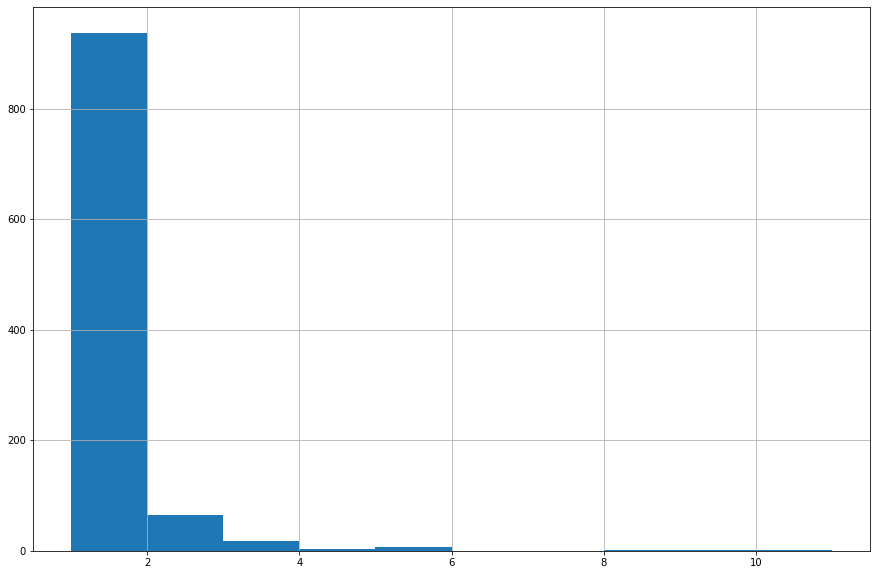

In [14]:
plt.figure(figsize=(15, 10))
plt.hist(ordersByUsers['transaction']) 
plt.grid()
plt.show()

* Гистограмма распределения показывает, что большинство пользователей сделало 1 заказ, тем не менее, есть некоторое количество пользователей, совершивших 2-6 заказов, а также более 8 заказов (похоже на аномальное значение, которое, возможно, придется исключить из анализа)

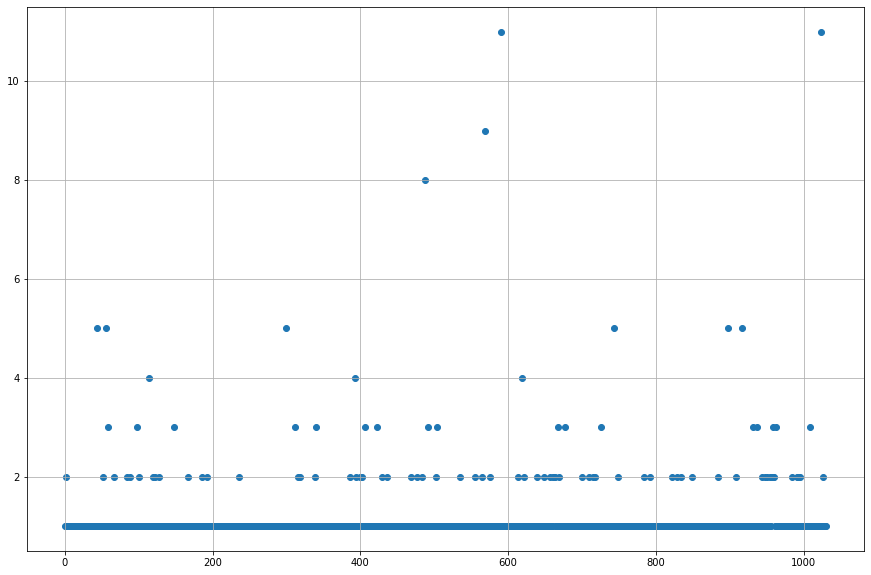

In [15]:
plt.figure(figsize=(15, 10))
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['transaction']) 
plt.grid()
plt.show()

* Анализ гистограммы и диаграммы рассеяния позволяет сделать вывод что наиболее распространенное количество заказов от 1 до 2х
* Процент пользователей, сделавших более 2 заказов заметно снижается

In [16]:
print(np.percentile(ordersByUsers['transaction'], [95, 99])) 

[2. 4.]


* Не более 5% пользователей совершали более 2 заказов
* Не более 1% пользователей совершали более 4 заказов
* Т.о. пользователей, сделавших более 2х заказов можно рассматривать как аномалию

#### График кумулятивной конверсии по группам <a class="anchor" id="seventh-bullet">

In [17]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [18]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [19]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [20]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5)) 


        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


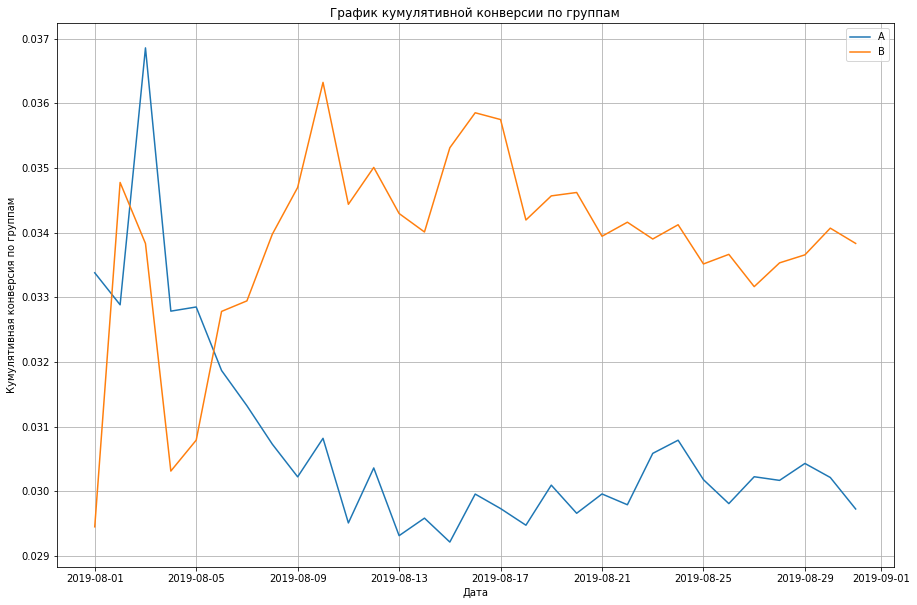

In [21]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15, 10))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам')
plt.xlabel("Дата")
plt.ylabel("Кумулятивная конверсия по группам")
plt.legend()
plt.grid()
plt.show()

* После 5.08 наблюдается снижение конверсии длягруппы А в 1,2 раза
* Для группы В наблюдается спад в это же период, после которого происходит рост и конверсия держится на уровне 0,034 без резких скачков 

#### График относительного изменения кумулятивной конверсии группы B к группе A <a class="anchor" id="eight-bullet">

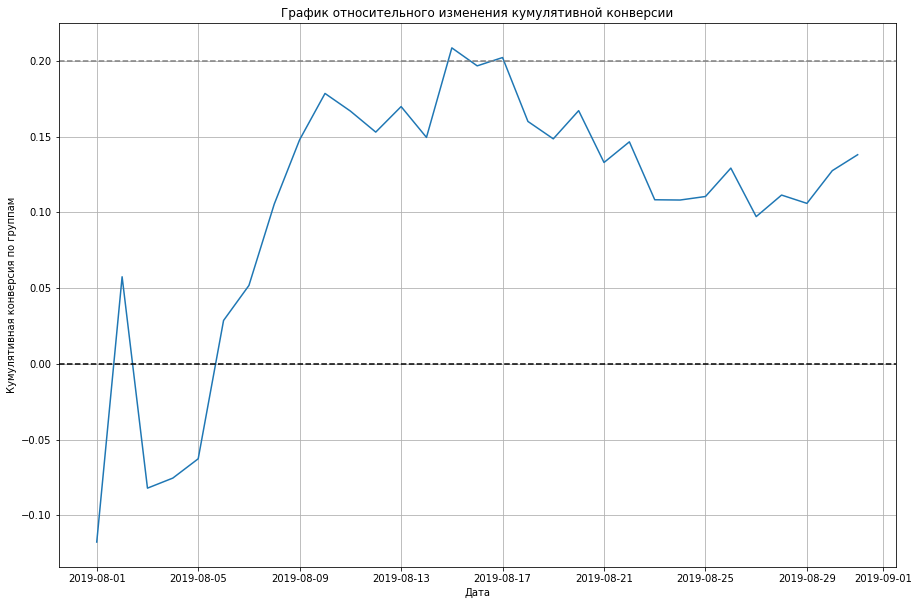

In [22]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15, 10))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивной конверсии')
plt.xlabel("Дата")
plt.ylabel("Кумулятивная конверсия по группам")
plt.grid()
plt.show()

* Группа В лидирует по конверсии практически все время, за исключением периода 2.08 - 5.08
* Относительный прирост конверсии группы В достигает значения 0.2 17.08, далее происходит снижение

#### График кумулятивной выручки по группам <a class="anchor" id="ninth-bullet">

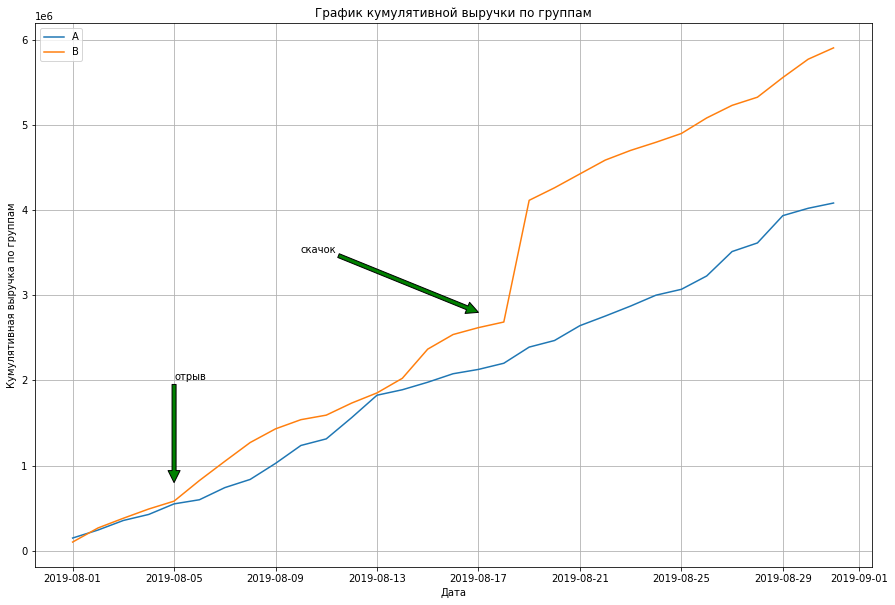

In [23]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(15, 10))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.xlabel("Дата")
plt.ylabel("Кумулятивная выручка по группам")
plt.annotate('скачок', xy=(dt.datetime(2019, 8, 17), 2800000), xytext=(dt.datetime(2019, 8, 10), 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=(dt.datetime(2019, 8, 5), 800000), xytext=(dt.datetime(2019, 8, 5), 2000000),
            arrowprops=dict(facecolor='g'))
plt.legend()
plt.grid()
plt.show()

* График кумулятивной выручки по группам показывает что до 5.08 выручка растет и ее увеличение одинаково для групп А и B
* Далее в период 5.08 - 18.08 характер распределение одинаков, при этом, для группы В наблюдается увеличение значений по сравнению с группой А
* После 18.08 кумулятивная выручка группы В скачкообразно растет и с этого момента доконца месяца в 1,5 раза превышает выручку группы А

#### График кумулятивного среднего чека по группам<a class="anchor" id="tenth-bullet">

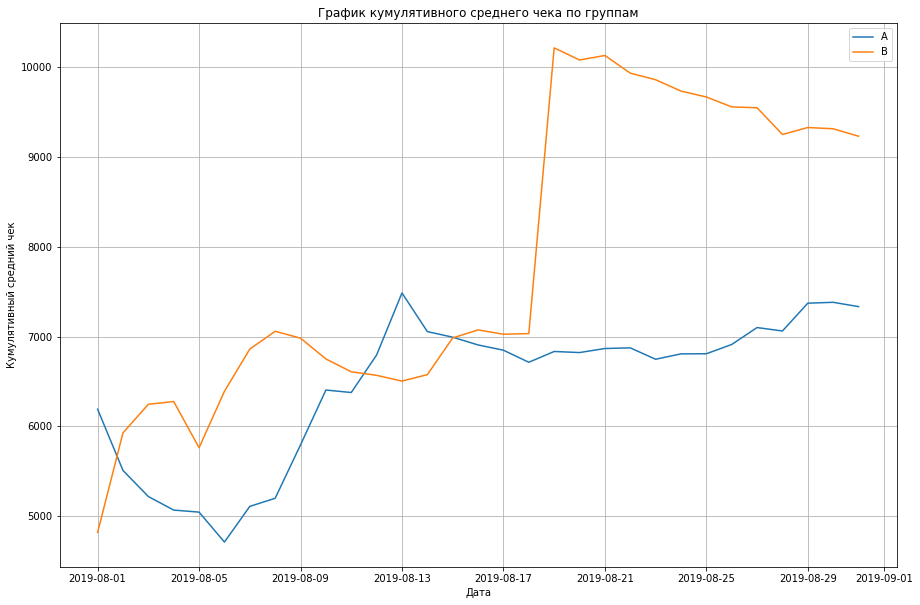

In [24]:
plt.figure(figsize=(15,10))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.legend()
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel("Дата")
plt.ylabel("Кумулятивный средний чек")
plt.legend()
plt.grid()
plt.show()

* Наблюдается скачок значений среднего чека для группы В после 17.08 в 1,44 раз

#### График относительного изменения кумулятивного среднего чека группы B к группе A <a class="anchor" id="eleventh-bullet">

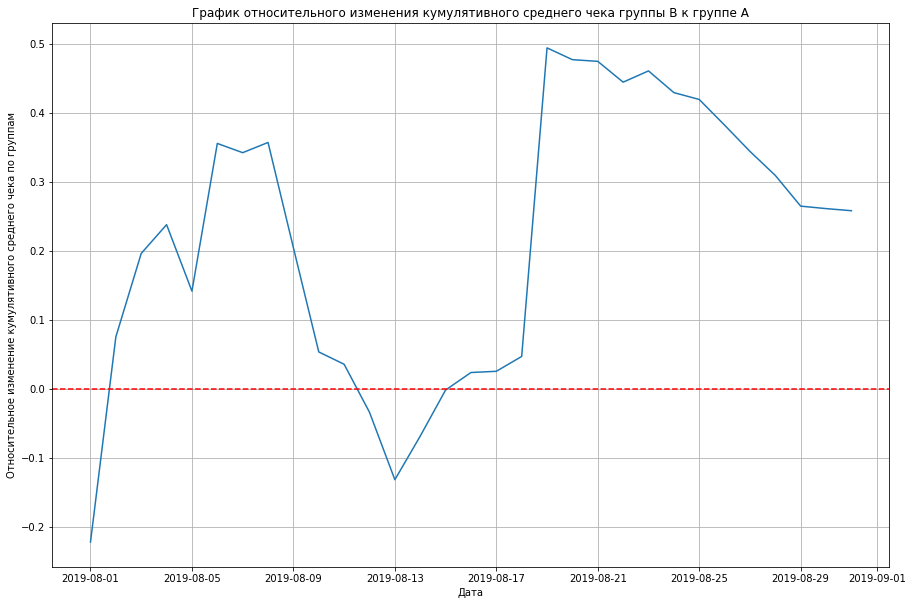

In [25]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15,10))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel("Дата")
plt.ylabel("Относительное изменение кумулятивного среднего чека по группам")
plt.grid()
plt.show()

График относительного изменения кумулятивного среднего чека группы B к группе A скачкообразный, с резкими перевадами в данных, что может указывать на наличие аномалий.

#### Подсчет статистической значимости различий в конверсии между группами по «сырым» данным <a class="anchor" id="twelveth-bullet">

Сформулируем нулевую и альтернативную гипотезы:
    
* H₀ - Вероятность того, что наблюдение из популяции B превышает наблюдение из популяции A равна 50%
* H₁ - Вероятность того, что наблюдение из популяции B превышает наблюдение из популяции A не равна 50%

Оценим статистическую значимость различий в конверсии между группами по «сырым» данным — т.е. без удаления аномальных пользователей.

In [26]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

In [27]:
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [28]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

In [29]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5))

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [30]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 


In [31]:
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

0        0
1        0
2        0
3        0
4        0
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: orders, Length: 18233, dtype: int64

In [32]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [33]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']


In [34]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))
          

0.017
0.138


P-value меньше 0.05, т.о нулевую гипотезу можно отвергнуть. Анализ "сырых" данных показывает наличие татистически значимых различий в конверсии между группами.

#### Оценка статистической значимости различия средних чеков между группами <a class="anchor" id="therteen-bullet">

Сформулируем нулевую и альтернативную гипотезы: 
* H₀ - Средний чек группы A равен среднему чеку группы B
* H₁ - Средний чек группы A не равен среднему чеку группы B

In [35]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.729
0.259


P-value больше 0.05 - статистически значимых отличий в среднем чеке между группами нету, можно принять нулевую гипотезу.

#### Очищение данных от аномалий <a class="anchor" id="fourteen-bullet">

Приступаем к подготовке очищенных от аномалий данных.
Напомним, что 95-й и 99-й перцентили средних чеков равны 28000 и 58233 рублям. А 95-й и 99-й перцентили числа заказов на одного пользователя равны 2 и 4 заказам на пользователя.
Примем за аномальных пользователей тех, кто совершил 3 заказа и более, или совершил заказ на сумму свыше 28 000 рублей.

In [36]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
abnormalUsers.shape

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64


(74,)

#### Подсчёт статистической значимости различий в конверсии между группами по «очищенным» данным <a class="anchor" id="fifteen-bullet">

Посчитаем статистическую значимость различия среднего количества заказов после удаления аномальных пользователей.
Создадим переменные sampleAFiltered и sampleBFiltered, в которых сохраним очищенные данные о заказах — не включая аномальных пользователей.

* H₀ - Вероятность того, что наблюдение из популяции B превышает наблюдение из популяции A равна 50%
* H₁ - Вероятность того, что наблюдение из популяции B превышает наблюдение из популяции A не равна 50%

In [37]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 



0.01304
0.173


Как и в случае с сырыми данными, статистическая значимость достигнута. Сегмент В значительно лучше сегмента А. Отвергаем H₀

#### Подсчет статистической значимости различия средних чеков после удаления аномальных пользователей <a class="anchor" id="sixteen-bullet">

Посчитаем статистическую значимость различия средних чеков после удаления аномальных пользователей.
Выведем p-value для сравнения средних чеков между очищенными группами. Округлим p-value до трёх знаков после запятой. Выведем относительный прирост среднего чека очищенной группы B, округлив до трёх знаков после запятой.

* H₀ - Средний чек A равен среднему чеку группы B
* H₁ - Средний чек A не равен среднему чеку группы B

In [38]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.738
-0.020


После очистки данных от аномалий p-value по среднему чеку не изменился т.е. статистически значимых отличий между группами нет, отвергаем нулевую гипотезу

### Выводы А/В теста <a class="anchor" id="seventeen-bullet">

* Наблюдается статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
* Как по сырым, так и по отфильтрованным данным нет статистически значимого различия по среднему чеку между группами
* График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту

###  Общие выводы <a class="anchor" id="eighteen-bullet">

* Были загружены данные, предварительно проанализированы: пропуски и дубликаты в данных не выявлены.
* Произведена предобработка данных: исправлены заголовки столбцов, изменен тип данных в столбцах с датами
* Проведена приоритизацию гипотез: с применением фреймворков ICE и RICE, проанализировано извенение приоритезации гипотез
* Без учета охвата самая приоритетная гипотеза 8 (запустить акцию на день рождения), а с учетом охвата самая приоритетная - 7 (добавить форму подписки на основные страницы) 
* Проведен А/В тест:
    * Построены графики кумулятивной выручки по группам
    * Построены графики кумулятивного среднего чека по группам
    * Построены графики относительного изменения кумулятивного среднего чека группы B к группе A
    * Построены графики кумулятивной конверсии по группам
    * Построены графики относительного изменения кумулятивной конверсии группы B к группе A, точечный график количества заказов по пользователям
    * Посчитаны перцентили количества заказов на пользователя 
    * Построены точечные графики стоимостей заказов, посчитаны перцентили стоимости заказов
    * Посчитана статистическая значимость различий в конверсии между группами по «сырым» данным
    * Посчитана статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным
    * Произведена осчистку данных от аномалий
    * Посчитана статистическая значимость различий в конверсии между группами по «очищенным» данным
    * Посчитана статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

* Стоимость не более чем 5% заказов более 28000 рублей, количество не более чем 5% заказов больше 2. Пользователи со стоимостью заказов более 28000 рублей и с количеством заказов более 2 можно считать аномальными
* Есть статистически значимое различие по конверсии между группами как по сырым данным, так и без учета аномалий
* Как по сырым, так и по отфильтрованным данным - нет статистически значимого различия по среднему чеку между группами 
* Результаты группы B имеют тенденцию к росту
* Исходя из обнаруженных фактов, тест следует остановить (Значения комулятивных метрик стабилизировались) и признать его успешным. 
* Средний чек остался без изменений, при этом, конверсия выросла. 
* Конверсия группы В больше чем группы А, т.к., при этом, средний чек одинаков, т.о. группа В приносит больше денежных средств бизнесу.